# Epicurious Data Analysis

**Autor:** Raphael Brito Alencar

**Descrição:** Análise dos dados coletados do site https://www.epicurious.com/

In [105]:
# carregando libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, norm, probplot

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag, word_tokenize
import re

import json
import gc

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rochelle0liveira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rochelle0liveira/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [106]:
# Utils
# percentual de preenchimento de cada feature
def show_filling_factor(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)'] = ((data.shape[0] - missing_df['missing values']) / data.shape[0]) * 100
    return missing_df.sort_values('filling factor (%)').reset_index(drop = True)

# histograma e normal probability plot
def create_hist_prob_plot(ser):
    sns.distplot(ser, fit=norm);
    fig = plt.figure()
    res = probplot(ser, plot=plt)
    
# transformar para log
def log_transform(ser):
    return ser.map(lambda i: np.log(i) if i > 0 else 0)

def fillna_outlier_median(col):
    # substituindo valores de outliers e valores faltantes pela mediana 
    IQR = iqr(data[col], nan_policy='omit')
    upper_bound = data[col].quantile(0.75) + 1.5 * IQR
    lower_bound = data[col].quantile(0.25) - 1.5 * IQR
    
    outliers = data[(data[col] > upper_bound) | (data[col] < lower_bound)]
    outliers_idx = outliers.index
    
    median = data[~data.isin(outliers)][col].median()
    
    data.loc[outliers_idx, col] = median
    data[col].fillna(median, inplace=True)
    
    return data[col].describe().round(decimals=2).drop('count')

def skew_kurt(col):
    # skewness e kurtosis
    print("Skewness: %f" % data[col].skew())
    print("Kurtosis: %f" % data[col].kurt())

def count_sublist_values(data,sublist):
    series = list()
    for i in data.index:
        try:
            t = data.loc[i, sublist]
            for j in t:
                series.append(j)
        except:
            pass
    return pd.Series(series)

def sublist_uniques(data,sublist):
    categories = set()
    for i in data.index:
        try:
            t = data.loc[i, sublist]
            for j in t:
                categories.add(j)
        except:
            pass
    return list(categories)

def sublists_to_binaries(data, sublist, index_key = None):
    categories = sublist_uniques(data,sublist)
    frame = pd.DataFrame(columns=categories)
    for i in data.index:
        if type(data.loc[i, sublist]) == list or np.array:
            try:
                if index_key != None:
                    key = data.loc[i, index_key]
                    f = np.zeros(len(categories))
                    for j in data.loc[i, sublist]:
                        f[categories.index(j)] = 1
                    if key in frame.index:
                        for j in data.loc[i, sublist]:
                            frame.loc[key][j]+=1
                    else:
                        frame.loc[key]=f
                else:
                    f = np.zeros(len(categories))
                    for j in data.loc[i, sublist]:
                        f[categories.index(j)] = 1
                    frame.loc[i]=f
            except:
                pass
                
    return frame

In [107]:
# carregando dados de receitas.json
# verificando os primeiros registros
data = pd.read_json('receitas.json')
data.head()

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7.0,"[4 cups low-sodium vegetable or chicken stock,...",30.0,2.500,559.0,"Lentil, Apple, and Turkey Wrap"
1,403.0,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23.0,"[1 1/2 cups whipping cream, 2 medium onions, c...",18.0,4.375,1439.0,Boudin Blanc Terrine with Red Onion Confit
2,165.0,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",2004-08-20 04:00:00,None,[In a large heavy saucepan cook diced fennel a...,7.0,"[1 fennel bulb (sometimes called anise), stalk...",6.0,3.750,165.0,Potato and Fennel Soup Hodge
3,NaN,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",2009-03-27 04:00:00,The Sicilian-style tomato sauce has tons of Me...,[Heat oil in heavy large skillet over medium-h...,NaN,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN,5.000,NaN,Mahi-Mahi in Tomato Olive Sauce
4,547.0,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",2004-08-20 04:00:00,None,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,"[1 12-ounce package frozen spinach soufflé, th...",20.0,3.125,452.0,Spinach Noodle Casserole


In [108]:
data.shape

(20130, 11)

In [109]:
# informações sobre as colunas do dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
calories       15976 non-null float64
categories     20111 non-null object
date           20111 non-null datetime64[ns]
desc           13495 non-null object
directions     20111 non-null object
fat            15908 non-null float64
ingredients    20111 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
sodium         15974 non-null float64
title          20111 non-null object
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 1.7+ MB


In [110]:
# descrevendo estatísticas dos valores numéricos
# resultado sem dados tratados
data.describe().round(decimals=2)

,calories,fat,protein,rating,sodium
count,15976.00,15908.00,15929.00,20100.00,15974.00
mean,6307.86,346.10,99.95,3.71,6211.47
std,358585.12,20431.02,3835.62,1.34,332890.25
min,0.00,0.00,0.00,0.00,0.00
25%,198.00,7.00,3.00,3.75,80.00
50%,331.00,17.00,8.00,4.38,294.00
75%,586.00,33.00,27.00,4.38,711.00
max,30111218.00,1722763.00,236489.00,5.00,27675110.00


Alguns fatos observados na descrição estatística das features:
* Temos valores extremos para fat, calories, protein e sodium
* Um alto numero de ratings 4.38, o que parece um erro

In [111]:
# verificando registros duplicados
print('Número de receitas duplicadas: {}'.format(data.duplicated('title').sum()))

Número de receitas duplicadas: 2354


In [112]:
# removendo registros duplicados
data.drop_duplicates('title', keep='first', inplace=True)
data.shape

(17776, 11)

In [113]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5859,67.039829
1,fat,3732,79.005401
2,protein,3713,79.112286
3,sodium,3689,79.247300
4,calories,3688,79.252925
5,rating,10,99.943744
6,categories,1,99.994374
7,date,1,99.994374
8,directions,1,99.994374
9,ingredients,1,99.994374


Olhando a tabela acima, parece que os registros nulos são os mesmos para categories, date, directions, ingredients e title. No caso, 1 registro. Verificando:

In [114]:
# tratando valores nulos
data[data['categories'].isna()]

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
1076,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# excluindo registros totalmente nulos
data.drop(data[data['categories'].isna()].index, inplace=True)

show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,fat,3731,79.009845
2,protein,3712,79.116737
3,sodium,3688,79.251758
4,calories,3687,79.257384
5,rating,9,99.949367
6,categories,0,100.000000
7,date,0,100.000000
8,directions,0,100.000000
9,ingredients,0,100.000000


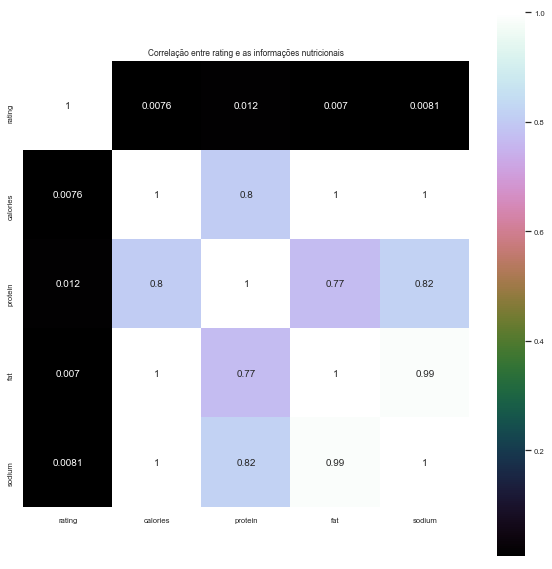

In [116]:
# verificando correlação entre variaveis numericas
cols = ['rating', 'calories', 'protein', 'fat', 'sodium']

plt.figure(figsize=(10,10))
sns.heatmap(data[cols].corr(), vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlação entre rating e as informações nutricionais')
plt.show()

As variáveis nutricionais se correlacionam de forma positiva de acordo com o coeficiente de Pearson mostrado no heatmap acima. Fica claro, também, que ás variáveis **sodium** e **calories** são as que se correlacionam melhor com a variável **rating**.

Vamos analisar cada variável separadamente para tirarmos algumas conclusões:

### rating

In [117]:
data['rating'].describe().round(decimals=2).drop('count')

mean    3.72
std     1.32
min     0.00
25%     3.75
50%     4.38
75%     4.38
max     5.00
Name: rating, dtype: float64

In [118]:
data[data['rating'].isna()]

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
560,508.0,[],2013-04-05 04:00:00,Although it's reason alone to keep a rotisseri...,"[Whisk chile, oil, lime juice, soy sauce, brow...",39.0,[1 red jalapeño or Fresno chile with some seed...,25.0,NaN,538.0,Asian Chicken and Cabbage Salad
1749,579.0,[],2012-11-27 04:00:00,We like to think of the summer roll as an eleg...,[Whisk together sauce ingredients in a bowl un...,22.0,"[2/3 cup hoisin sauce (see Cooks' notes:), 1/3...",20.0,NaN,1160.0,Spicy Summer Rolls with Peanut Dipping Sauce
3931,255.0,[],2013-01-07 04:00:00,Dark chocolate and espresso add the slightly b...,[Beat 1/2 cup cream in a medium bowl until sti...,17.0,"[3/4 cup chilled heavy cream, divided, 4 large...",5.0,NaN,74.0,Classic Chocolate Mousse
4036,NaN,[],2011-08-10 04:00:00,"At Philadelphia's Bindi, legumes and rice are ...","[Preheat oven to 450°F. Cut top 1/2"" off head ...",NaN,"[1 head of garlic, 1 tablespoon extra-virgin o...",NaN,NaN,NaN,South Indian Lentil Cakes with Raita
8262,117.0,[],2011-12-09 04:00:00,Our fresh take on the classic Moroccan salad p...,"[Preheat oven to 400°. Wash beets, leaving som...",0.0,"[2 medium red beets, tops trimmed, 2 medium go...",3.0,NaN,51.0,"Blood Orange, Beet, and Fennel Salad"
11763,NaN,[],2011-05-17 04:00:00,This is inspired by the Italian combination of...,"[Grill bread slices., Halve, pit, and thinly s...",NaN,"[12 slices ciabatta bread, 1 ripe peach, 1 tab...",NaN,NaN,NaN,"Peach, Prosciutto & Ricotta Crostini"
12077,355.0,[],2013-09-18 04:00:00,"When we were first dating, we would stay up in...",[Place pears and granulated sugar in a medium ...,18.0,"[2 Bosc or Anjou pears, peeled, cored and quar...",4.0,NaN,269.0,Tarte Bourdaloue
13781,NaN,[],2014-05-09 04:00:00,Crisp julienned vegetables add crunchy texture...,"[In a large bowl, whisk together tamari, 1 tab...",NaN,"[1/4 cup gluten-free tamari or soy sauce, 1/4 ...",NaN,NaN,NaN,Sesame Rice Noodles with Shrimp
16839,NaN,[],2014-03-26 04:00:00,Almonds are the new breadcrumbs. Their toasty ...,"[Mix almonds, chives, parsley, and 1 tablespoo...",NaN,"[1/2 cup unsalted, roasted almonds, coarsely c...",NaN,NaN,NaN,Linguine and Clams with Almonds and Herbs


Analisando os 9 registros com valores faltantes de **rating** percebe-se que a maior parte das features para esses registros são nulas. Excluí-los não deve afetar nossa análise.

In [119]:
data.drop(data[data['rating'].isna()].index, inplace=True)

In [120]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,fat,3727,79.021727
2,protein,3708,79.128673
3,sodium,3684,79.263762
4,calories,3683,79.269391
5,categories,0,100.000000
6,date,0,100.000000
7,directions,0,100.000000
8,ingredients,0,100.000000
9,rating,0,100.000000


Verificando a distribuição de **rating**:

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


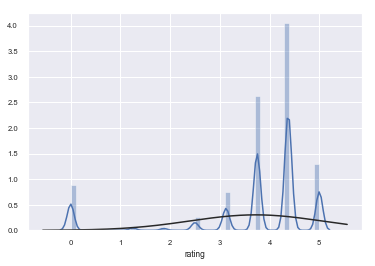

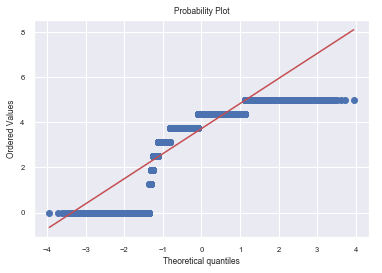

In [121]:
create_hist_prob_plot(data['rating'])

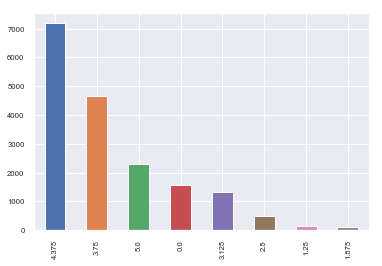

In [122]:
data['rating'].value_counts().plot.bar()
plt.show()

Um grande número de avaliações 4.375. Aparentemente algum erro!

### fat

In [123]:
data['fat'].describe().round(decimals=2).drop('count')

mean        373.50
std       21668.02
min           0.00
25%           9.00
50%          18.00
75%          35.00
max     1722763.00
Name: fat, dtype: float64

In [124]:
skew_kurt('fat')

Skewness: 74.252119
Kurtosis: 5747.229472


**Skewness** é o grau de distorção da curva simétrica ou da distribuição normal. Mede a falta de simetria na distribuição dos dados, diferenciando valores extremos. Uma distribuição simétrica terá skewness 0.

**Kurtosis** mostra tudo sobre a calda da distribuição. É usado para descrever os valores extremos, sendo na verdade a medida de outliers existentes na distribuição.

Percebemos um valor para o Kurtosis muito alto (High Kurtosis), indicando que temos muitos outliers. Vamos ajustá-los e também preencher os valores faltantes com a média, utilizando a técnica de **IQR Score**: 

In [125]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('fat')

mean    19.82
std     14.87
min      0.00
25%     11.00
50%     17.00
75%     24.00
max     74.00
Name: fat, dtype: float64

In [126]:
skew_kurt('fat')

Skewness: 1.333320
Kurtosis: 1.859364


In [127]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,protein,3708,79.128673
2,sodium,3684,79.263762
3,calories,3683,79.269391
4,categories,0,100.000000
5,date,0,100.000000
6,directions,0,100.000000
7,fat,0,100.000000
8,ingredients,0,100.000000
9,rating,0,100.000000


Apresentando a distribuição da variável **fat** e gerando um gráfico de probabilidade dos dados em relação aos quantis de uma distribuição normal:

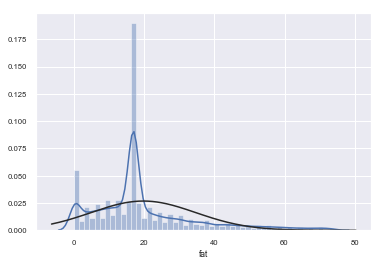

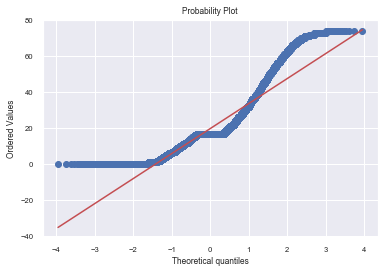

In [128]:
create_hist_prob_plot(data['fat'])

Plotando um boxplot para visualizar a posição, simetria, dispersão e valores discrepantes dos dados da feature **fat**:

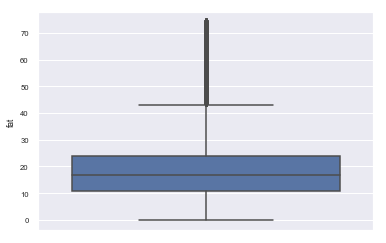

In [129]:
sns.boxplot(y=data['fat'])
plt.show()

### protein

In [130]:
data['protein'].describe().round(decimals=2).drop('count')

mean        94.60
std       3562.82
min          0.00
25%          3.00
50%          9.00
75%         29.00
max     236489.00
Name: protein, dtype: float64

In [131]:
skew_kurt('protein')

Skewness: 55.047617
Kurtosis: 3177.812071


A feature **protein** também possui muitos valores extremos. Vamos tratá-los junto com os valores faltantes assim como foi feito com fat.

In [132]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('protein')

mean    13.30
std     14.34
min      0.00
25%      5.00
50%      8.00
75%     16.00
max     68.00
Name: protein, dtype: float64

In [133]:
skew_kurt('protein')

Skewness: 1.777203
Kurtosis: 2.487228


In [134]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,sodium,3684,79.263762
2,calories,3683,79.269391
3,categories,0,100.000000
4,date,0,100.000000
5,directions,0,100.000000
6,fat,0,100.000000
7,ingredients,0,100.000000
8,protein,0,100.000000
9,rating,0,100.000000


Visualizando a distribuição de **protein**

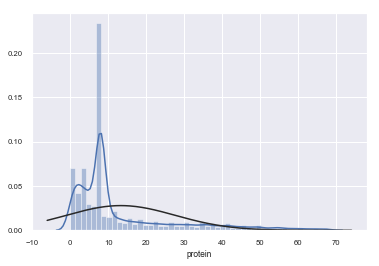

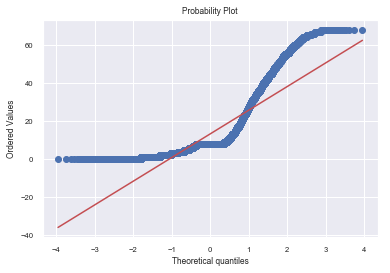

In [135]:
create_hist_prob_plot(data['protein'])

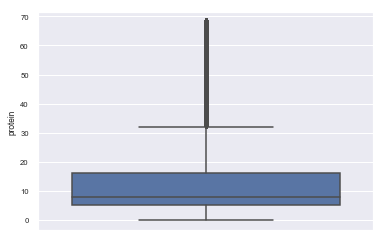

In [136]:
sns.boxplot(y=data['protein'])
plt.show()

### calories

In [137]:
data['calories'].describe().round(decimals=2).drop('count')

mean        6808.42
std       380315.15
min            0.00
25%          208.00
50%          351.00
75%          605.00
max     30111218.00
Name: calories, dtype: float64

In [138]:
skew_kurt('calories')

Skewness: 73.236272
Kurtosis: 5635.426321


Vamos resolver os valores faltantes e outliers de **calories** da mesma forma que os anteriores.

In [139]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('calories')

mean     377.61
std      225.54
min        0.00
25%      242.00
50%      327.00
75%      460.00
max     1200.00
Name: calories, dtype: float64

In [140]:
skew_kurt('calories')

Skewness: 1.246337
Kurtosis: 1.556509


In [141]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,sodium,3684,79.263762
2,calories,0,100.000000
3,categories,0,100.000000
4,date,0,100.000000
5,directions,0,100.000000
6,fat,0,100.000000
7,ingredients,0,100.000000
8,protein,0,100.000000
9,rating,0,100.000000


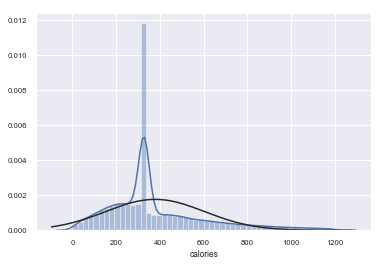

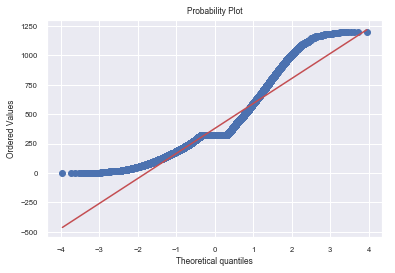

In [142]:
create_hist_prob_plot(data['calories'])

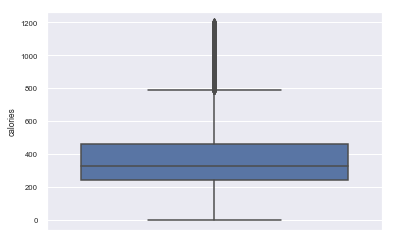

In [143]:
sns.boxplot(y=data['calories'])
plt.show()

### sodium

In [144]:
data['sodium'].describe().round(decimals=2).drop('count')

mean        6758.43
std       353561.36
min            0.00
25%           92.00
50%          310.00
75%          740.00
max     27675110.00
Name: sodium, dtype: float64

In [145]:
skew_kurt('sodium')

Skewness: 71.340269
Kurtosis: 5396.853017


In [146]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('sodium')

mean     368.81
std      352.50
min        0.00
25%      137.00
50%      268.00
75%      462.00
max     1712.00
Name: sodium, dtype: float64

In [147]:
skew_kurt('sodium')

Skewness: 1.609521
Kurtosis: 2.240760


In [148]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,calories,0,100.000000
2,categories,0,100.000000
3,date,0,100.000000
4,directions,0,100.000000
5,fat,0,100.000000
6,ingredients,0,100.000000
7,protein,0,100.000000
8,rating,0,100.000000
9,sodium,0,100.000000


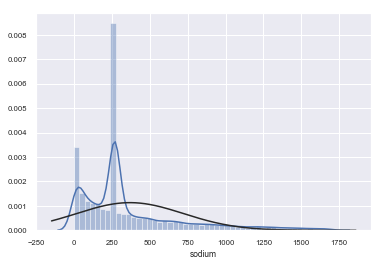

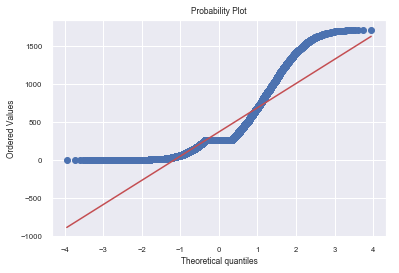

In [149]:
create_hist_prob_plot(data['sodium'])

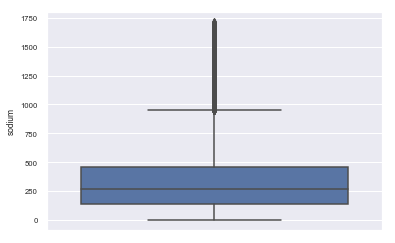

In [150]:
sns.boxplot(y=data['sodium'])
plt.show()

### categories

Verificando as 10 categorias mais utilizadas:

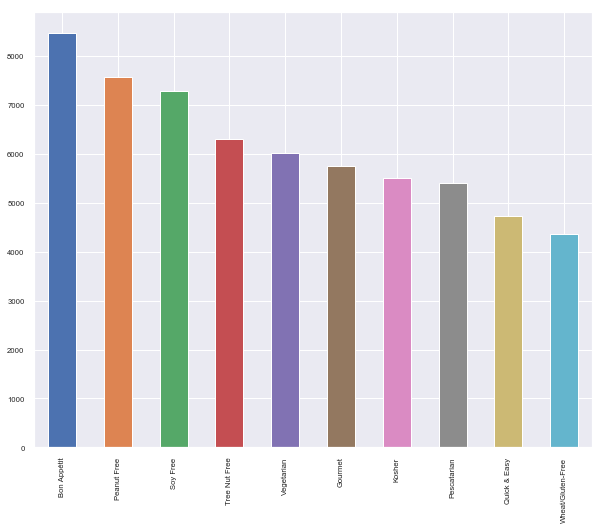

Em um total de  673 categorias


In [151]:
# Quantas vezes cada categoria aparece
cat = count_sublist_values(data, 'categories')

# plot top 10 categorias usadas
plt.figure(figsize=(10,8))
cat.value_counts().nlargest(10).plot.bar()
plt.show()

unique_cat = sublist_uniques(data, 'categories')
print('Em um total de  \u001b[1m{} categorias'.format(len(unique_cat)))

#### 1) A que categorias pertencem as comidas mais calóricas?
* Foram selecionadas as 5 receitas mais caloricas para a análise

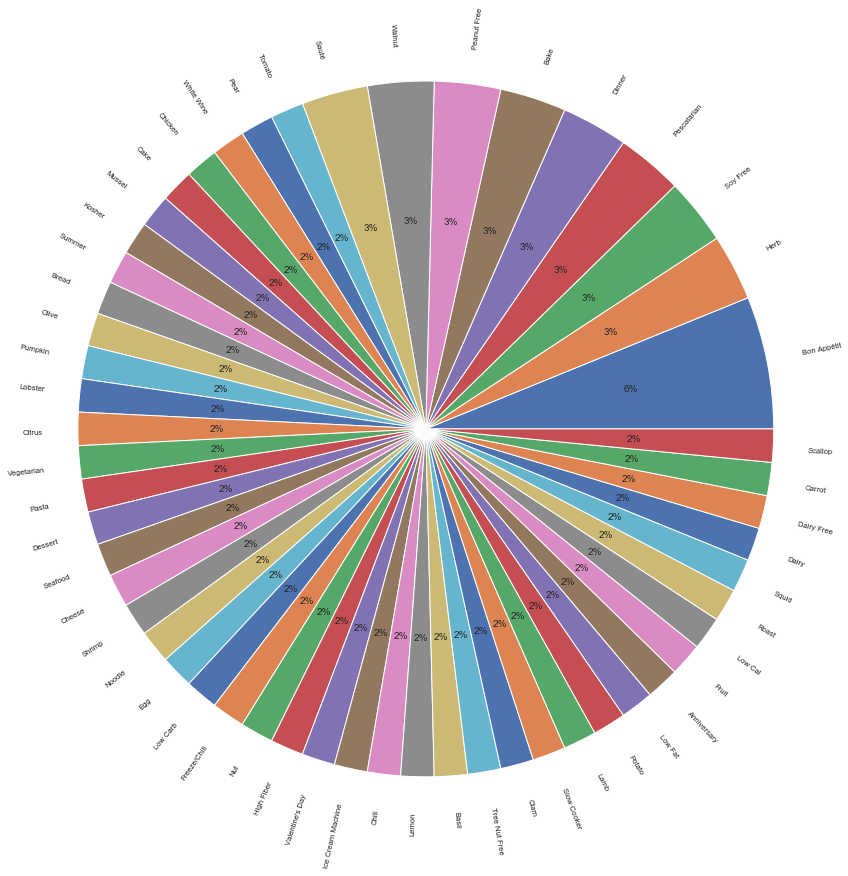

In [152]:
# 5 receitas mais caloricas e suas categorias
cal_receipts = data.nlargest(5, columns='calories')
cal_receipts_unique_cat = count_sublist_values(cal_receipts, 'categories')

plt.figure(figsize=(8, 8))
cal_receipts_unique_cat.value_counts().plot.pie(rotatelabels=True, autopct='%1.0f%%', radius=2.0)
plt.show()

**6%** das **receitas mais calóricas** são categorizadas com **Bon Appétit**, sendo essa a categoria mais comum num total de **54** usadas nas receitas mais caóricas.

### ingredients

In [153]:
data.reset_index(drop=True, inplace=True)

# extraindo ingredientes de cada registro
recipe_ingredients = [] # armazena os ingredientes de cada receita
ingredients_list = [] # lista com todos ingredientes presentes nos dados

for i in range(len(data['ingredients'])):
    recipe_ingredients.append([])
    
    for j in range(len(data['ingredients'][i])):
        tokenized_ingredients = nltk.word_tokenize(data['ingredients'][i][j])
        
        # lista de tags https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html    
        tagged_ingredients = nltk.pos_tag(tokenized_ingredients)         
        tagged_ingredients = [k for k in tagged_ingredients if (k[1] == 'NN' or k[1] == 'NNS') and (re.match('[^0-9]', k[0]))]
        tagged_ingredients = tagged_ingredients[-1:]
        
        if len(tagged_ingredients) != 0:
            recipe_ingredients[i].append(tagged_ingredients[0][0]) # adicionando apenas o token
            ingredients_list.append(tagged_ingredients[0][0])

#### 2) Quais os top 10 ingredientes contidos nas receitas mais calóricas?

In [154]:
# transformando a coluna ingredients
ingredients = pd.Series(recipe_ingredients, name='ingredients')
data['ingredients'] = ingredients
data.head()

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7.0,"[stock, lentils, lentils, celery, carrot, thym...",30.0,2.500,559.0,"Lentil, Apple, and Turkey Wrap"
1,403.0,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23.0,"[cream, onions, salt, leaves, cloves, clove, p...",18.0,4.375,1439.0,Boudin Blanc Terrine with Red Onion Confit
2,165.0,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",2004-08-20 04:00:00,None,[In a large heavy saucepan cook diced fennel a...,7.0,"[garnish, onion, butter, potatoes, broth, milk]",6.0,3.750,165.0,Potato and Fennel Soup Hodge
3,327.0,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",2009-03-27 04:00:00,The Sicilian-style tomato sauce has tons of Me...,[Heat oil in heavy large skillet over medium-h...,17.0,"[oil, onion, wine, paste, juice, fillets, oliv...",8.0,5.000,268.0,Mahi-Mahi in Tomato Olive Sauce
4,547.0,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",2004-08-20 04:00:00,None,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,"[soufflé, noodles, cream, sauce, nutmeg, cheese]",20.0,3.125,452.0,Spinach Noodle Casserole


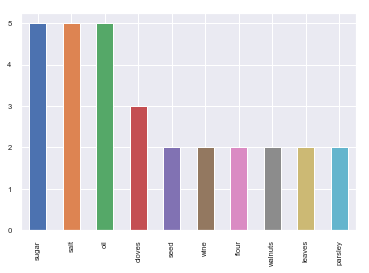

In [155]:
# retornando as receitas mais caloricas
cal_receipts = data.nlargest(5, columns='calories')
cal_receipts_unique_ing = count_sublist_values(cal_receipts, 'ingredients')
cal_receipts_unique_ing.value_counts().nlargest(10, keep='first').plot.bar() 
plt.show()

Era de se esperar que sal, açucar e oleo fossem os ingredientes mais utilizados. Estes são ingredientes quase que indispensáveis em receitas mais caloricas.

#### 3) Se você tivesse que recomendar 3 receitas baseando-se nos dados, quais seriam?

Uma boa receita é aquela que tem valores nutricionais balanceados. Para o caso, uma receita com baixa caloria e alta proteína deve ser uma boa escolha.

In [199]:
# selecionando as receitas com avaliação 5.0
five_aval_recipe = data[data['rating'] == 5.0]
print('A base de dados é composta por {} receitas com avaliação 5.0'.format(five_aval_recipe.shape[0]))

A base de dados é composta por 2311 receitas com avaliação 5.0


In [200]:
# dividindo os dados em intervalos de tamanho igual de acordo com os quantis da amostra de dados
# e armazenando em uma coluna calories_bin 
a = pd.qcut(five_aval_recipe['calories'], [0, .33, .66, 1], labels=['low', 'med', 'high']).rename('calories_bin')

five_aval_recipe = five_aval_recipe.join(a)

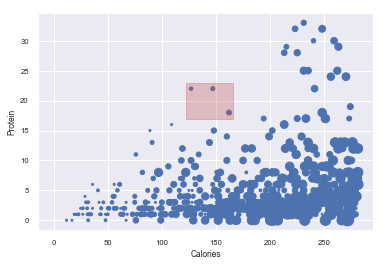

In [209]:
# selecionando receitas com avaliação 5.0 e baixa caloria
low = five_aval_recipe.loc[five_aval_recipe['calories_bin'] == 'low']

# plotando calories x protein com os tamanhos das marcas baseado na variavel fat
plt.scatter(x='calories', y='protein', s=low['fat'] * 4, data=low)

plt.xlabel('Calories')
plt.ylabel('Protein')

# marcando as 3 receitas a serem recomendadas
plt.axhspan(ymin=17, ymax=23, xmin=.44, xmax=.58, alpha=.3, color='r')
plt.show()

In [213]:
# selecionando as 3 receitas demarcadas no retangulo vermelho
low.loc[(low['protein'] > 17) & (low['calories'] < 170)]

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title,calories_bin
5117,162.0,"[Soup/Stew, turkey, Thanksgiving, Low Fat, Low...",2007-10-01 21:17:01,All of the gravy recipes here call for this en...,"[In large saucepan, combine low-salt chicken b...",6.0,"[broth, chunks, chunks, onion, parsley, gizzard]",18.0,5.0,278.0,Shortcut Turkey Stock,low
5793,127.0,"[Sauce, Soup/Stew, Onion, turkey, Thanksgiving...",2004-08-20 04:00:00,None,[Cut neck crosswise into 1 1/2-inch pieces. Me...,3.0,"[turkey, butter, onions, carrots, leaves, brot...",22.0,5.0,95.0,Giblet Stock,low
13243,147.0,"[turkey, Marinate, Roast, Thanksgiving, Dinner...",2008-09-30 04:00:00,This recipe has subtle Asian flavors that deli...,[Coarsely grind first 5 ingredients in spice m...,4.0,"[anise*, peppercorns**, cloves, seeds, seeds, ...",22.0,5.0,763.0,"Salted Roast Turkey with Orange, Fall Spices, ...",low


In [218]:
suggested_recipe = low.loc[(low['protein'] > 17) & (low['calories'] < 170), 'title']
print('3 Receitas sugeridas: ')

for rec in suggested_recipe.values:
    print('\033[1m' + rec + '\033[0m')

3 Receitas sugeridas: 
Shortcut Turkey Stock 
Giblet Stock 
Salted Roast Turkey with Orange, Fall Spices, and Sherry Gravy 


Sendo assim, as 3 receitas sugeridas são:

#### 4) Alguma característica presente nos dados determina a alta nota de uma receita?

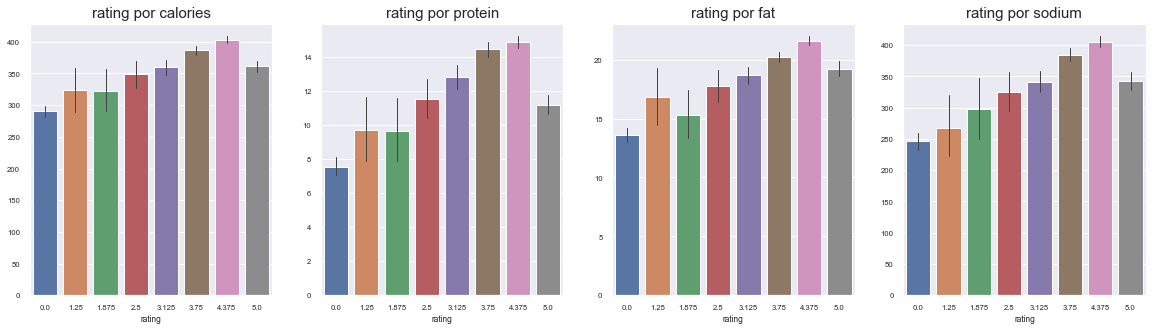

In [76]:
dict_plt = {0:'calories',1:'protein',2:'fat',3:'sodium'}

sns.set(font_scale=.7)

fig, ax = plt.subplots(1, 4, figsize=(20,5))

for i in range(4):
    sns.barplot(x='rating',y=dict_plt[i], data=data, ax=ax[i], errwidth=1)
    ax[i].set_title('rating por {}'.format(dict_plt[i]), size=15)
    ax[i].set_ylabel('')

De acordo com os gráficos de barras acima, identifica-se que as receitas com melhor avaliação são aquelas **mais calóricas** e com **muito sódio**. 

#### 5) Considerando-se as categorias das top 100 receitas em avaliação, quantas receitas há atualmente no site https://www.epicurious.com para cada categoria

In [55]:
# usando as ultimas de acordo com a data
top_100_rating_recipe = data.sort_values('date', ascending=False).nlargest(100, columns='rating')
top_100_rating_recipe

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
4660,935.0,"[Vegetarian, Rice, Dinner, Orange, Parsnip, Ri...",2016-11-27 18:46:20.583,This simple rice salad combines hearty parsnip...,[Arrange a rack in center of oven; preheat to ...,65.0,"[rice, oil, salt, oranges, coins, clove, sprig...",18.0,5.0,1061.0,Vegetarian Brown Rice Salad With Parsnips and ...
15610,631.0,"[Friendsgiving, Thanksgiving, Dinner, Butternu...",2016-11-24 02:46:00.000,"For maximum juiciness and flavor, pound and se...","[Working one at a time, place turkey breast, s...",36.0,"[breasts, salt, pepper, fennel, oil, casings, ...",59.0,5.0,1335.0,"Stuffed Turkey Breast With Butternut Squash, K..."
8481,122.0,"[Bread, Dinner, Christmas, Thanksgiving, Bake,...",2016-11-23 20:30:00.000,"One simple master recipe, based on a classic F...",[Heat milk in a small saucepan over low until ...,5.0,"[milk, teaspoons, salt, flour, honey, tablespo...",2.0,5.0,243.0,Dinner Rolls Six Ways
6319,409.0,"[Bon Appétit, Thanksgiving, Pie, Sweet Potato/...",2016-11-22 17:36:17.100,We tested this pie recipe with canned sweet po...,[Heat butter and brown sugar in a small saucep...,26.0,"[butter, sugar, seeds, pieces, salt, pound, su...",6.0,5.0,334.0,Sweet Potato–Miso Pie With Chocolate-Sesame Cr...
17256,549.0,"[Bon Appétit, Thanksgiving, Stuffing/Dressing,...",2016-11-21 23:33:04.148,This holiday-worthy recipe was inspired by bre...,"[Preheat oven to 300°F. Butter a shallow 13x9""...",36.0,"[butter, cups, oil, casings, onions, stalks, s...",23.0,5.0,865.0,Cheesy Sausage and Sage Stuffing
11613,327.0,"[Bon Appétit, Thanksgiving, Side, Leafy Green,...",2016-11-21 23:25:10.578,"For this recipe, the greens taste best if saut...",[Remove ribs and stems from Swiss chard leaves...,17.0,"[chard, vinegar, sauce, sugar, oil, bacon, oni...",8.0,5.0,268.0,Braised Swiss Chard With Bacon and Hot Sauce
16782,605.0,"[Bon Appétit, Phyllo/Puff Pastry Dough, Butter...",2016-11-21 23:17:55.570,When overlapping the phyllo over the filling i...,[Place a rack in lower third of oven; preheat ...,34.0,"[brushing, onions, pieces, thyme, flakes, cros...",26.0,5.0,763.0,"Skillet Phyllo Pie With Butternut Squash, Kale..."
13358,327.0,"[Bon Appétit, Thanksgiving, turkey, Bourbon, G...",2016-11-21 21:21:18.536,Separate cooking techniques for breast and leg...,"[Mix salt, pepper, granulated sugar, and papri...",17.0,"[salt, ground, sugar, paprika, turkey, crosswi...",8.0,5.0,268.0,Bourbon and Brown Sugar Glazed Turkey
6434,344.0,"[Bon Appétit, Tofu, Pork, Quick & Easy, Ginger...",2016-11-21 21:09:29.259,"Spicy, mouth-tingling, porky: Those are the wo...",[Heat oil in a small heavy pot over medium-hig...,25.0,"[oil, pork, jalapeño, cloves, ginger, scallion...",22.0,5.0,116.0,Weeknight Mapo Tofu With Ground Pork
17035,327.0,"[Bon Appétit, Steak, Chile Pepper, Garlic, Cas...",2016-11-21 20:35:04.181,It’s Tostada Night! Just hearing those words m...,[Preheat oven to 350°F. Roast chiles and garli...,17.0,"[chiles, cloves, cashews, vinegar, sugar, salt...",8.0,5.0,268.0,Skirt Steak Tostadas With Cashew Salsa and Red...


In [66]:
top_100_cat_recipe = count_sublist_values(top_100_rating_recipe, 'categories')

# top 100 categorias das top 100 receitas em avaliação
cat100 = top_100_cat_recipe.value_counts().nlargest(100).index
for cat in cat100:
    count = 0
    print('\033[1m' + cat + '\033[0m')
    for i in data.index:
        val = data.loc[i,'categories']
        if cat in val:
            count+=1
    print('{} receitas.\n'.format(count))

Bon Appétit
8470 receitas.

Dinner
2535 receitas.

Summer
3762 receitas.

Peanut Free
7564 receitas.

Dessert
3153 receitas.

Soy Free
7279 receitas.

Vegetarian
6027 receitas.

Wheat/Gluten-Free
4357 receitas.

Tree Nut Free
6302 receitas.

Pescatarian
5399 receitas.

Kosher
5511 receitas.

Garlic
1438 receitas.

Thanksgiving
1228 receitas.

Chile Pepper
210 receitas.

HarperCollins
117 receitas.

Salad
1432 receitas.

Dairy Free
2853 receitas.

Tomato
1961 receitas.

Lime Juice
118 receitas.

No Sugar Added
2792 receitas.

Bake
4035 receitas.

Chicken
1240 receitas.

Fall
2676 receitas.

Pork
872 receitas.

Kidney Friendly
1955 receitas.

Breakfast
677 receitas.

Chocolate
769 receitas.

Milk/Cream
1791 receitas.

Cilantro
532 receitas.

Pie
20 receitas.

Herb
1490 receitas.

Quick & Easy
4728 receitas.

Roast
1173 receitas.

Bread
428 receitas.

Side
2710 receitas.

Ginger
1030 receitas.

Lemon
982 receitas.

Appetizer
1305 receitas.

Braise
302 receitas.

Winter
2768 receitas.

Coc